<a href="https://colab.research.google.com/github/nicovakr/Pytorch-init/blob/master/DeepNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Network on GPU

In [2]:
import numpy as np
import matplotlib
import torch
import torchvision
import torchaudio

In [10]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff' #white background for figures

In [6]:
dataset = MNIST(root='data/', download = True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



image.shape: torch.Size([1, 28, 28])
Label: 5


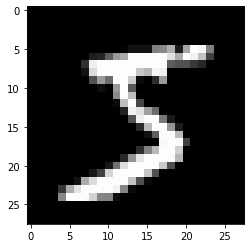

In [26]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(np.squeeze(image), cmap='gray')
# np.squeeze(image) ou image.permute(1, 2, 0)
print('Label:', label)

In [27]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [28]:
batch_size = 128

In [29]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
# num_workers : number of subprocesses to use for data loading
#               if zero = data loaded in the main process
# pin_memory : True => the data loader will copy Tensors intpo CUDA pinned memory before returning them

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


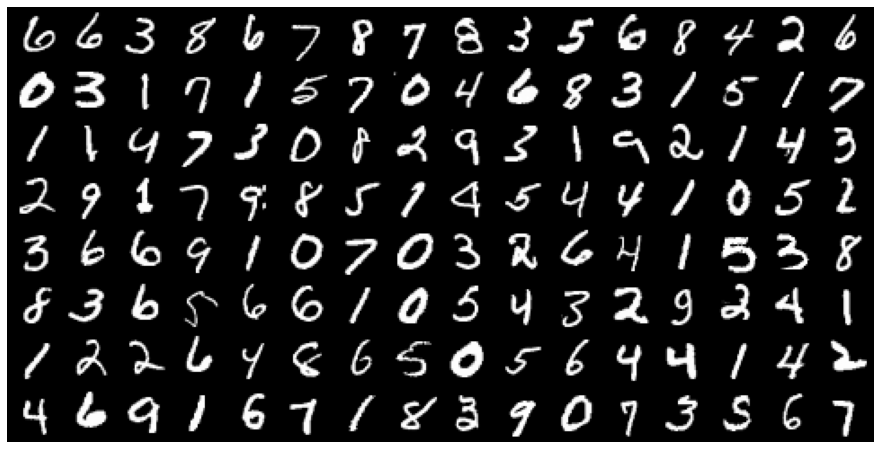

In [30]:
for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
  break

In [31]:
for images, labels in train_loader:
  print('images.shape:', images.shape)
  inputs = images.reshape(-1, 784)
  print('inputs.shape:', inputs.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [32]:
input_size = inputs.shape[-1]
hidden_size = 32 # learning capacity of the model

In [33]:
layer1 = nn.Linear(input_size, hidden_size)

In [34]:
inputs.shape

torch.Size([128, 784])

In [35]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [36]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [37]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [38]:
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [39]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6942804455757141
min(relu_outputs): 0.0
